# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [596]:
# Import essential libraries for data manipulation and analysis
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [597]:
# Importing the file porter_data_1.csv
df = pd.read_csv("porter_data_1.csv")
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [598]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
print(df.dtypes)

market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_primary_category               int64
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_dashers              float64
total_busy_dashers                 float64
total_outstanding_orders           float64
distance                           float64
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [599]:
# Convert categorical features to category type

categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']

# Converting into category type
for col in categorical_cols:
    df[col] = df[col].astype('category')
print(df.dtypes)

market_id                         category
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_primary_category            category
order_protocol                    category
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_dashers              float64
total_busy_dashers                 float64
total_outstanding_orders           float64
distance                           float64
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [600]:
# Calculate time taken in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60
df.head()

market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  delivery_time_minutes  
0                      21.0     34.44                   47.0  
1                       2.0     27.60                   44.0  
2                      18.0     11.56                   55.0  
3                       8.0     31.80                   59.0  
4                       7.0      8.20                   46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [601]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
# (Day starts from Monday with 0 = Monday)
df['order_day_of_week'] = df['created_at'].dt.dayofweek


# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df.head()

market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  delivery_time_minutes  order_hour  \
0                      21.0     34.44                   47.0          22   
1                       2.0     27.60                   44.0          21   
2                      18.0     11.56                   55.0           0   
3                       8.0     31.80                   59.0           3   
4                       7.0      8.20                   46.0           2   

   order_day_of_week  isWeekend  
0                  4          0  
1                  1          0  
2                  0          0  
3                  3          0  
4                  1          0

In [602]:
# Drop unnecessary columns
columns_to_drop = ['created_at', 'actual_delivery_time', 'min_item_price', 'max_item_price']

# Drop the columns
df = df.drop(columns=columns_to_drop, errors='ignore')

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [603]:
# Define target variable (y) and features (X)
# Delivery time will be the target variable
y = df['delivery_time_minutes']

# All columns excluding the delivery time is Featerues
X = df.drop(columns=['delivery_time_minutes'], errors='ignore')


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [604]:
# Split data into training and testing sets

np.random.seed(0)
X_train, X_test, y_train, y_test  = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

# Print the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (123043, 13)
X_test shape: (52734, 13)
y_train shape: (123043,)
y_test shape: (52734,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

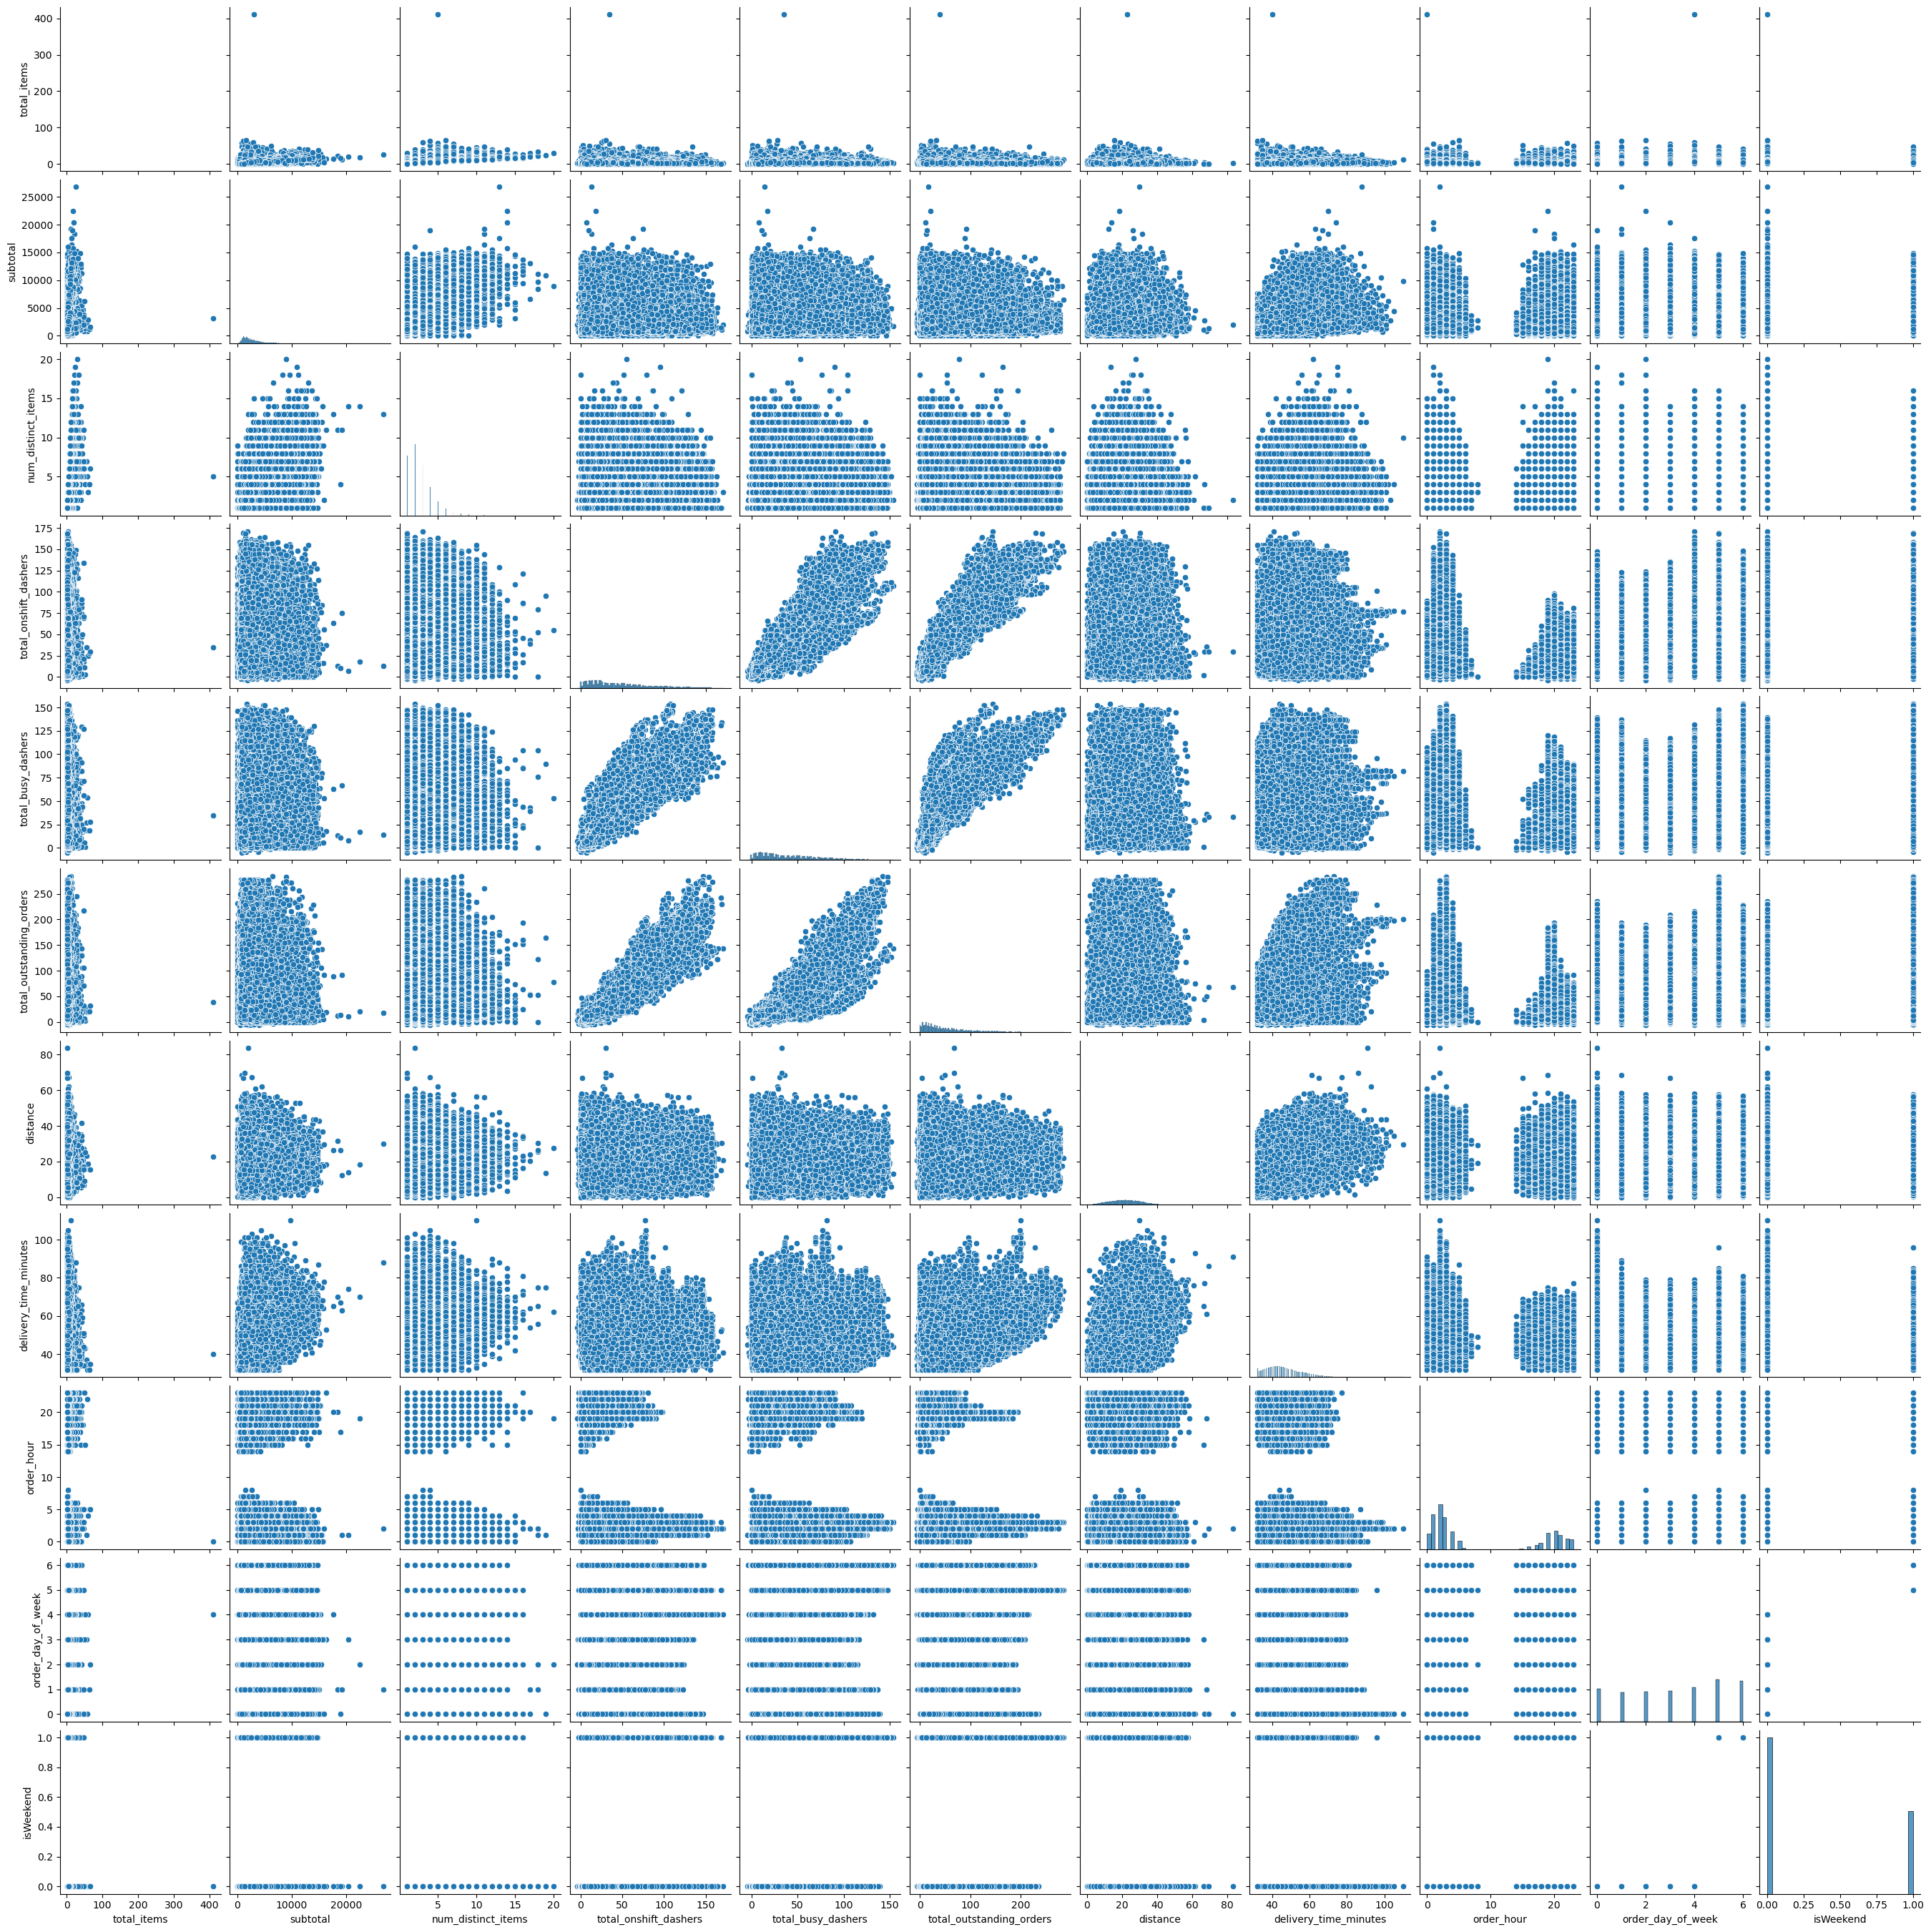

In [50]:
# Plot distributions for all numerical columns
sns.pairplot(df)
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

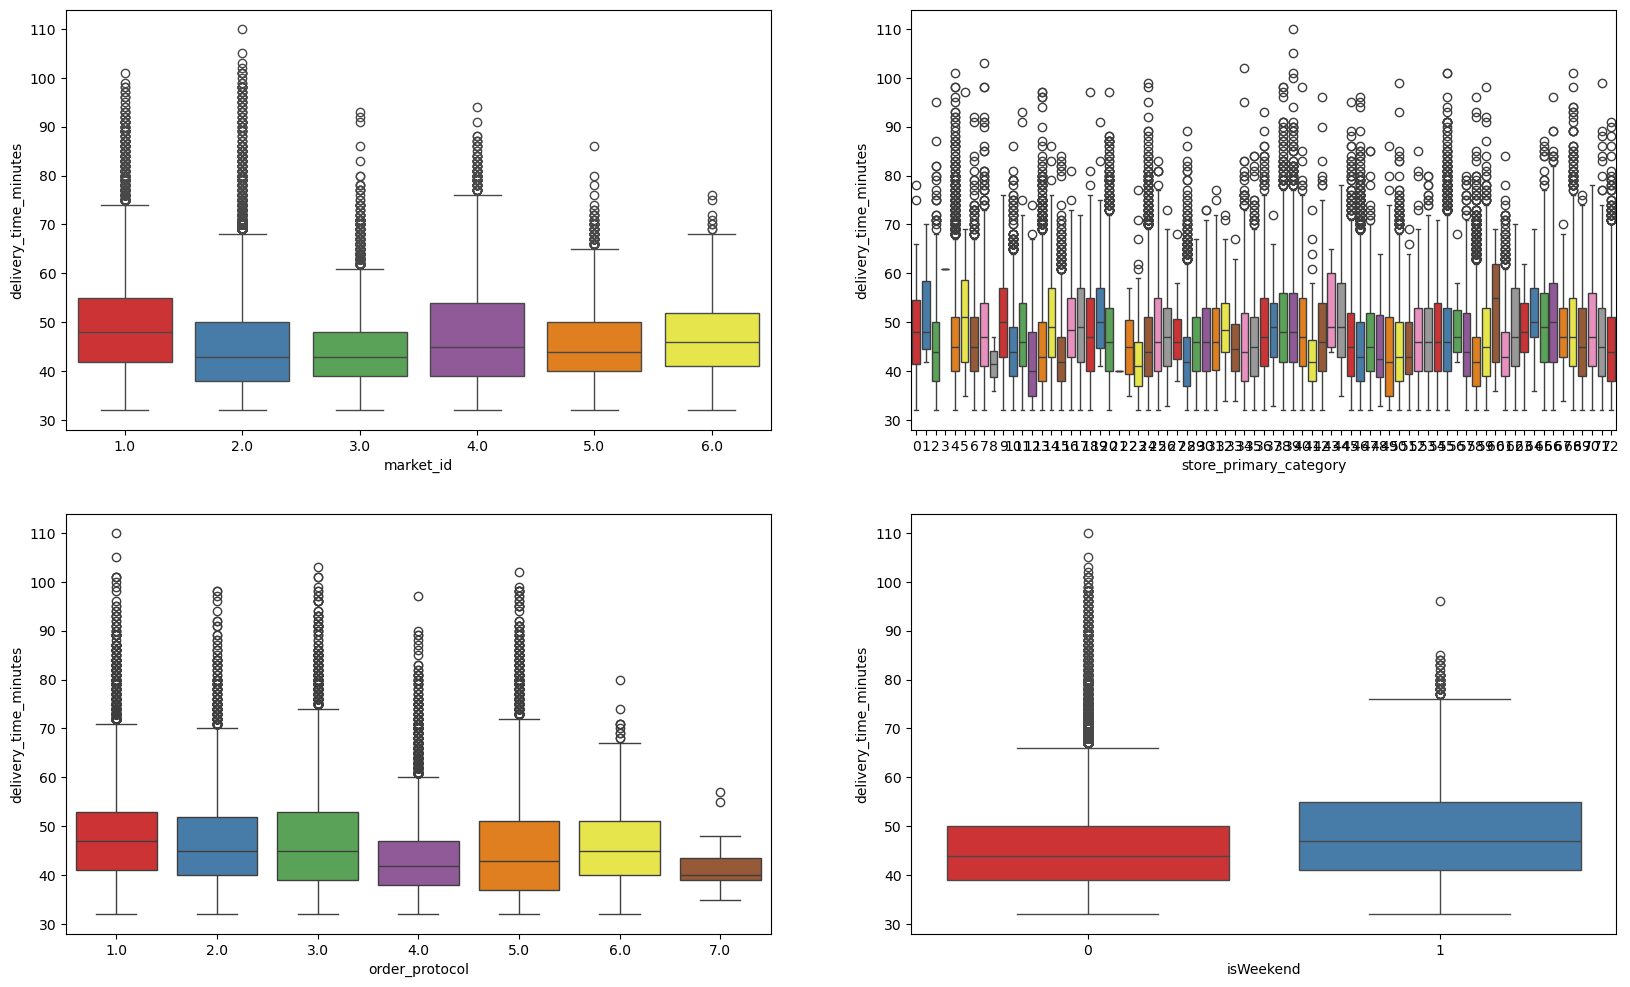

In [605]:
# Distribution of categorical columns
plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
sns.boxplot(x = 'market_id', y = 'delivery_time_minutes', data = df,  palette='Set1')
plt.subplot(2,2,2)
sns.boxplot(x = 'store_primary_category', y = 'delivery_time_minutes', data = df, palette='Set1')
plt.subplot(2,2,3)
sns.boxplot(x = 'order_protocol', y = 'delivery_time_minutes', data = df, palette='Set1')
plt.subplot(2,2,4)
sns.boxplot(x = 'isWeekend', y = 'delivery_time_minutes', data = df, palette='Set1')
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

<Axes: xlabel='delivery_time_minutes', ylabel='Count'>

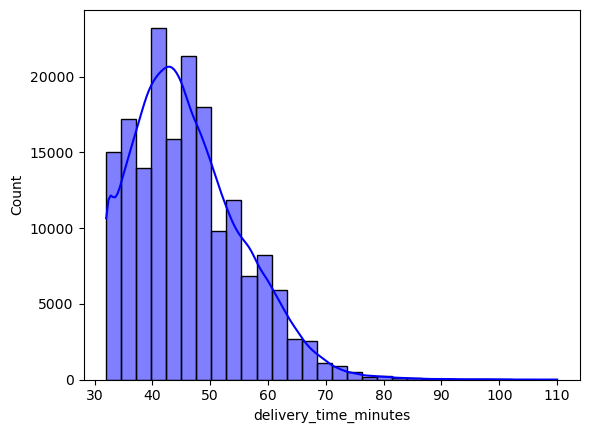

In [606]:
# Distribution of time_taken
sns.histplot(y, bins=30, kde=True, color="blue")


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

<Axes: xlabel='total_items', ylabel='delivery_time_minutes'>

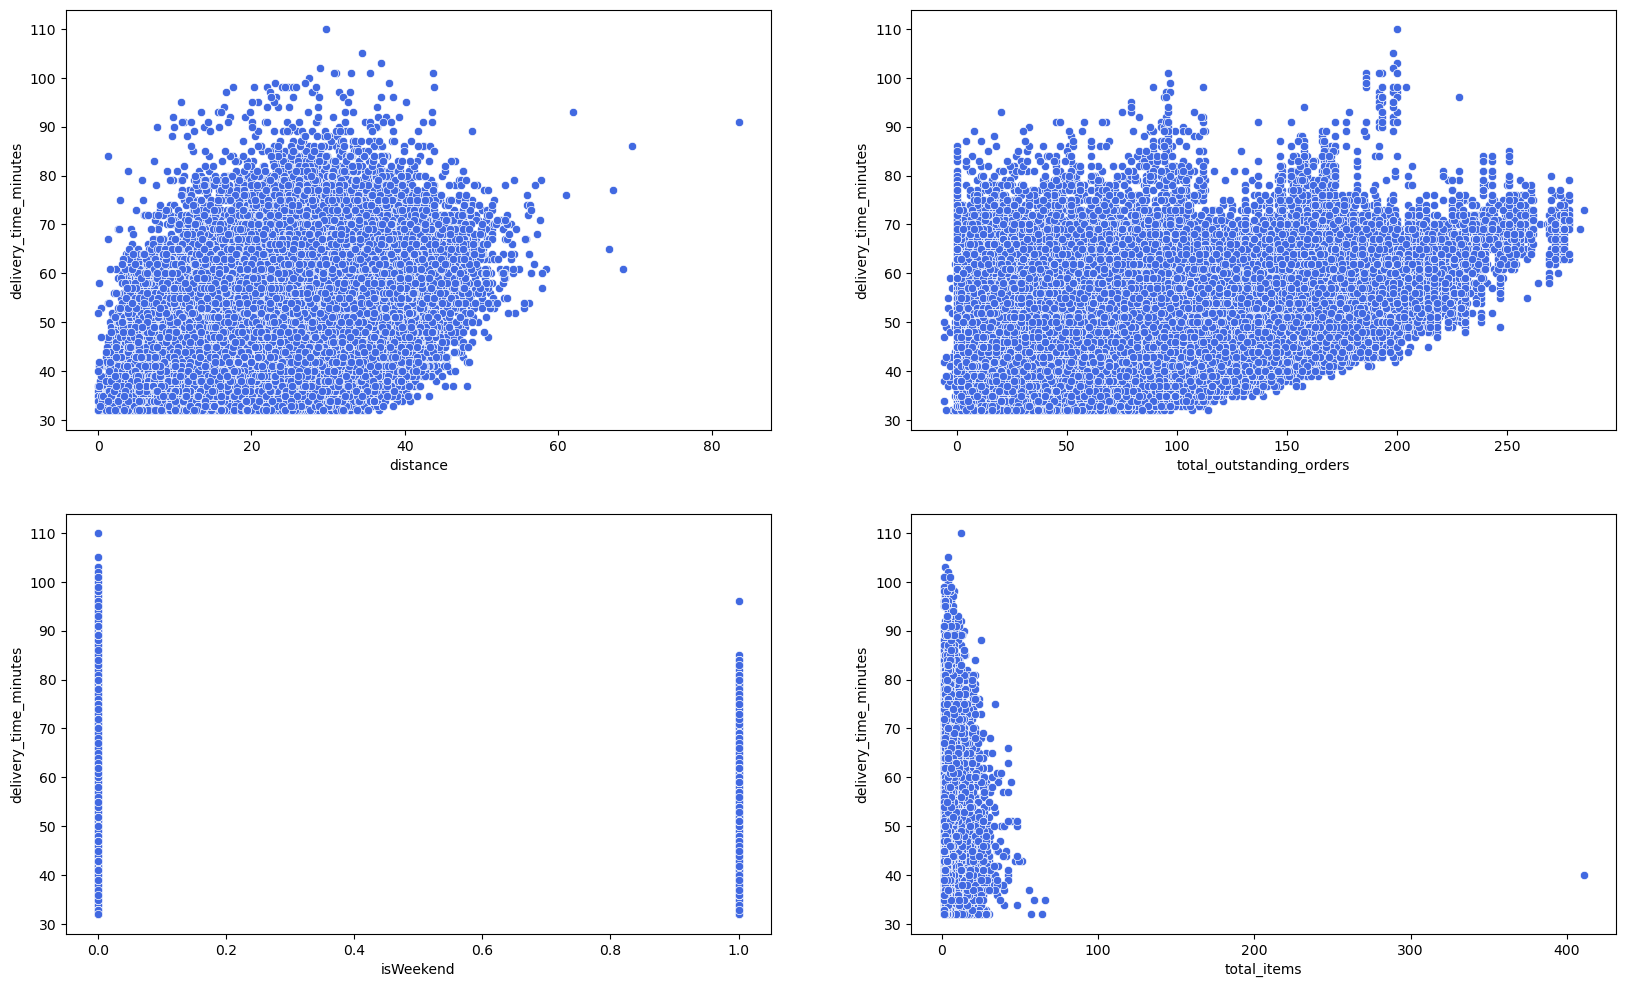

In [607]:
# Scatter plot to visualise the relationship between time_taken and other features

plt.figure(figsize=(20, 12))
plt.subplot(2,2,1)
# Scatter plot between delivery time and distance
sns.scatterplot(x=X['distance'], y=y, color="royalblue")
plt.subplot(2,2,2)
sns.scatterplot(x=X['total_outstanding_orders'], y=y, color="royalblue")
plt.subplot(2,2,3)
sns.scatterplot(x=X['isWeekend'], y=y, color="royalblue")
plt.subplot(2,2,4)
sns.scatterplot(x=X['total_items'], y=y, color="royalblue")

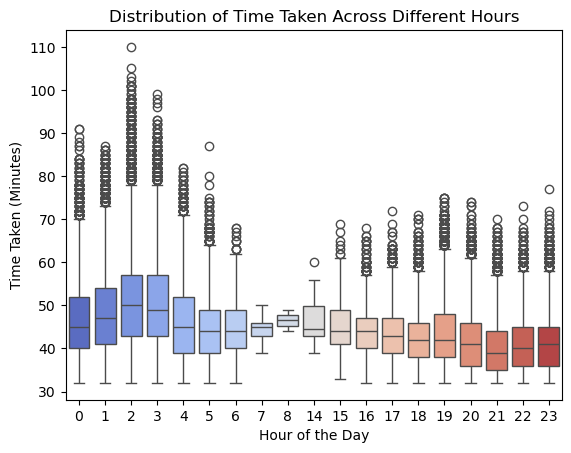

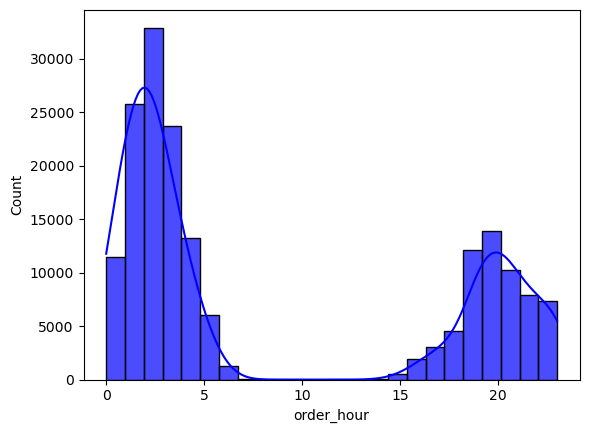

In [608]:
# Show the distribution of time_taken for different hours
sns.boxplot(x=X['order_hour'], y=y, palette="coolwarm")
plt.xlabel("Hour of the Day")
plt.ylabel("Time Taken (Minutes)")
plt.title("Distribution of Time Taken Across Different Hours")
plt.show()


sns.histplot(data=X, x="order_hour",  bins=24, kde=True, color="blue", alpha=0.7)
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

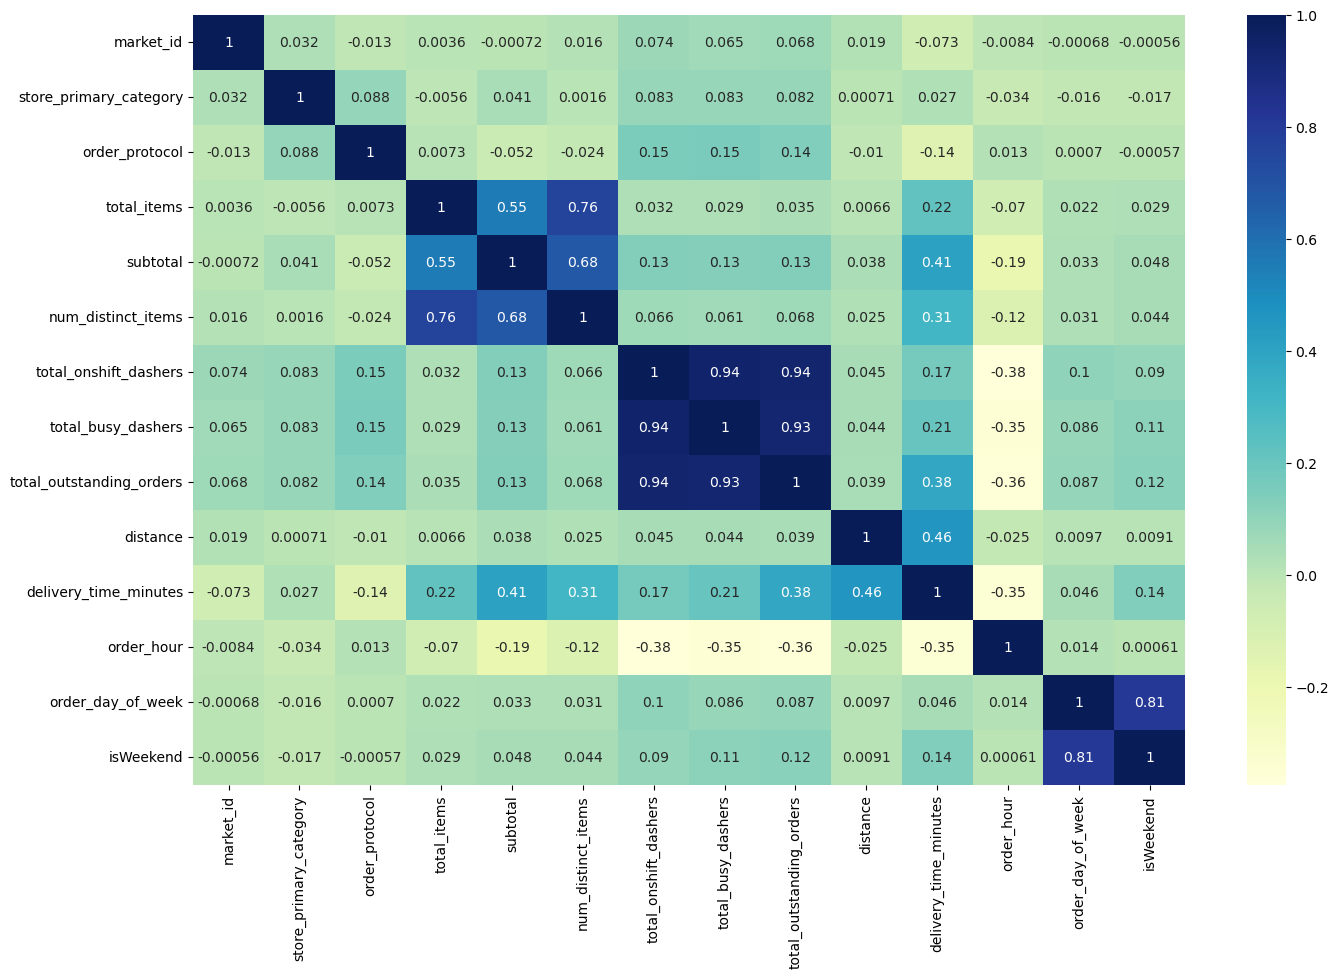

In [609]:
# Plot the heatmap of the correlation matrix
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [610]:
# Drop 3-5 weakly correlated columns from training dataset
columns_to_drop = ["order_protocol","order_day_of_week","store_primary_category","market_id"]
df = df.drop(columns=columns_to_drop, axis=1)

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

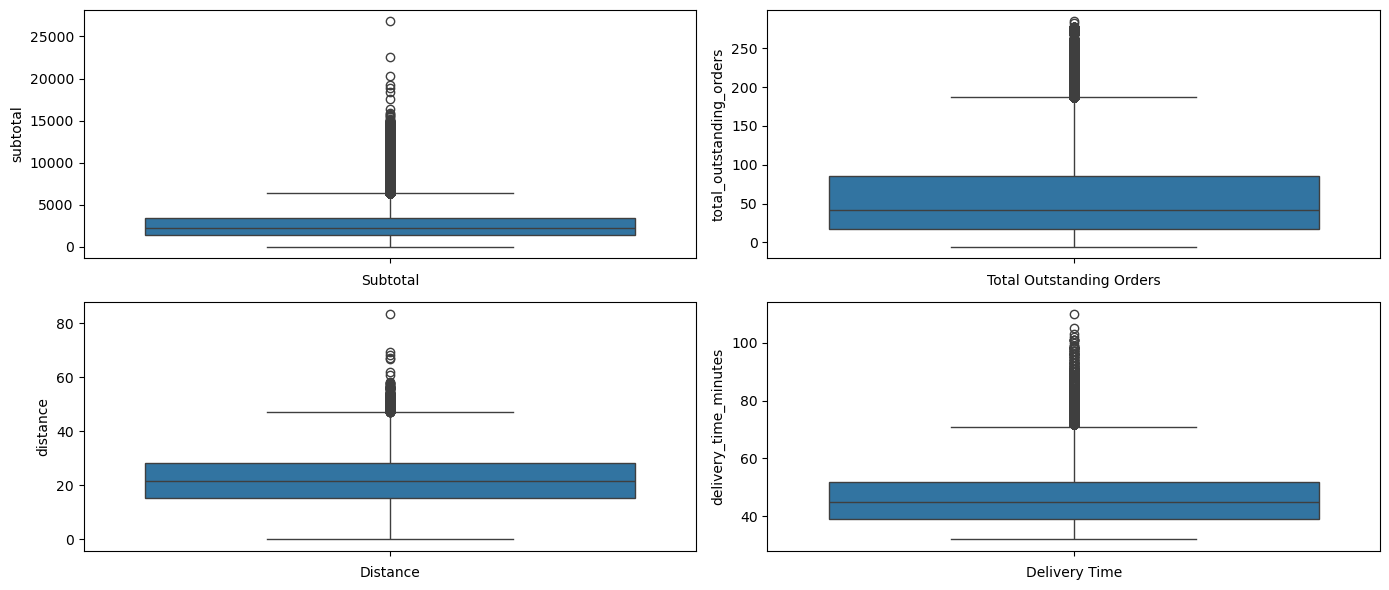

In [611]:
# Boxplot for time_taken
fig, axes = plt.subplots(2, 2, figsize=(14, 6))  

# First Boxplot: Subtotal vs Time Taken
sns.boxplot(df["subtotal"], ax=axes[0,0])
axes[0,0].set_xlabel("Subtotal")

# Second Boxplot: Total Outstanding Orders vs Time Taken
sns.boxplot(df["total_outstanding_orders"], ax=axes[0,1])
axes[0,1].set_xlabel("Total Outstanding Orders")

# Second Boxplot: Total Outstanding Orders vs Time Taken
sns.boxplot(df["distance"], ax=axes[1,0])
axes[1,0].set_xlabel("Distance")

# Second Boxplot: Total Outstanding Orders vs Time Taken
sns.boxplot(df["delivery_time_minutes"], ax=axes[1,1])
axes[1,1].set_xlabel("Delivery Time")



# Adjust layout
plt.tight_layout()
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [612]:
# Handle outliers
df = df[df["subtotal"] <= 15000]

df = df[df["total_outstanding_orders"] <= 200]

df = df[df["distance"] <= 60]

df = df[df["delivery_time_minutes"] <= 70]

df.describe()

total_items       subtotal  num_distinct_items  \
count  171246.000000  171246.000000       171246.000000   
mean        3.183187    2668.197797            2.656798   
std         2.657576    1795.467157            1.606011   
min         1.000000       0.000000            1.000000   
25%         2.000000    1400.000000            1.000000   
50%         3.000000    2200.000000            2.000000   
75%         4.000000    3388.000000            3.000000   
max       411.000000   14955.000000           20.000000   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
count          171246.000000       171246.000000             171246.000000   
mean               43.558536           40.547423                 55.186965   
std                33.152244           30.824422                 48.432301   
min                -4.000000           -5.000000                 -6.000000   
25%                17.000000           15.000000                 17.000000   
50%                36.000000           34.000000                 40.000000   
75%                64.000000           61.000000                 82.000000   
max               171.000000          154.000000                200.000000   

            distance  delivery_time_minutes     order_hour      isWeekend  
count  171246.000000          171246.000000  171246.000000  171246.000000  
mean       21.752392              45.627804       8.633002       0.339371  
std         8.706359               8.598708       8.729584       0.473497  
min         0.000000              32.000000       0.000000       0.000000  
25%        15.280000              39.000000       2.000000       0.000000  
50%        21.680000              45.000000       3.000000       0.000000  
75%        28.000000              51.000000      19.000000       1.000000  
max        58.400000              70.000000      23.000000       1.000000

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [622]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
df.head()

total_items  subtotal  num_distinct_items  total_onshift_dashers  \
0            4      3441                   4                   33.0   
1            1      1900                   1                    1.0   
2            4      4771                   3                    8.0   
3            1      1525                   1                    5.0   
4            2      3620                   2                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  \
0                14.0                      21.0     34.44   
1                 2.0                       2.0     27.60   
2                 6.0                      18.0     11.56   
3                 6.0                       8.0     31.80   
4                 5.0                       7.0      8.20   

   delivery_time_minutes  order_hour  isWeekend  isPeakHour  
0                   47.0          22          0           1  
1                   44.0          21          0           1  
2                   55.0           0          0           1  
3                   59.0           3          0           1  
4                   46.0           2          0           1

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [629]:
# Apply scaling to the numerical columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# adding peak hour column
df['isPeakHour'] = df['order_hour'].apply(lambda x: 1 if (x >= 19 or x < 5) else 0)

# splitting data into train and test set
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

num_vars = ['subtotal', 'num_distinct_items','total_onshift_dashers','total_busy_dashers','total_outstanding_orders', 'distance', 'delivery_time_minutes','order_hour',"total_items","isWeekend","isPeakHour"]

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()


total_items  subtotal  num_distinct_items  total_onshift_dashers  \
115667    -0.799034 -0.162248           -1.031845               0.496782   
94275     -0.432277 -0.591595           -0.408225               0.466598   
21408      0.667992  0.470357            1.462633               0.074211   
72784     -0.432277 -1.056025           -1.031845              -1.072765   
63081     -0.065521  0.473698            0.215394              -0.106890   

        total_busy_dashers  total_outstanding_orders  distance  \
115667            0.632610                  0.781598 -1.923203   
94275             0.730083                  0.616290 -0.705445   
21408             0.177736                  0.265010 -1.619912   
72784            -1.056922                 -0.933473 -0.457298   
63081             0.047772                 -0.416886 -1.858868   

        delivery_time_minutes  order_hour  isWeekend  isPeakHour  
115667              -0.305249   -0.760721  -0.715641    0.334596  
94275               -0.886848    1.186331  -0.715641    0.334596  
21408                0.043710   -0.875254   1.397349    0.334596  
72784               -0.305249    1.300864  -0.715641    0.334596  
63081               -1.584767    1.300864  -0.715641    0.334596

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [630]:
# Create/Initialise the model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

y_train = df_train.pop('delivery_time_minutes')
X_train = df_train

In [631]:
# Train the model using the training data
import statsmodels.api as sm

# Add a constant
X_train_lm = sm.add_constant(X_train)

# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()


In [632]:
# Make predictions
df_test[num_vars] = scaler.transform(df_test[num_vars])

y_test = df_test.pop('delivery_time_minutes')
X_test = df_test

X_test = sm.add_constant(X_test)

y_train_pred = lr.predict(X_train_lm)
y_pred = lr.predict(X_test)


In [633]:
# Find results for evaluation metrics

print(lr.summary())

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)


                              OLS Regression Results                             
Dep. Variable:     delivery_time_minutes   R-squared:                       0.859
Model:                               OLS   Adj. R-squared:                  0.859
Method:                    Least Squares   F-statistic:                 7.296e+04
Date:                   Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                           05:31:49   Log-Likelihood:                -52721.
No. Observations:                 119872   AIC:                         1.055e+05
Df Residuals:                     119861   BIC:                         1.056e+05
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [635]:
# Loop through the number of features and test the model

# Adding only most correlated ones - distance & subtotal
X_train_lm = X_train[['distance', 'subtotal']]
X_train_lm = sm.add_constant(X_train_lm)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

#  low R-Squared value. We will add more features - total_outstanding_orders
X_train_lm = X_train[['distance', 'subtotal','total_outstanding_orders']]
X_train_lm = sm.add_constant(X_train_lm)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())
# By adding total_outstanding_orders R square value increased further

# We will try adding more features- order_hour
X_train_lm = X_train[['distance', 'subtotal','total_outstanding_orders', 'order_hour']]
X_train_lm = sm.add_constant(X_train_lm)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())
# We managed to increas the R square value close to .5 by adding order_hour

# We will add more features - num_distinct_items
X_train_lm = X_train[['distance', 'subtotal','total_outstanding_orders', 'order_hour', 'num_distinct_items']]
X_train_lm = sm.add_constant(X_train_lm)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

# We will add more features - total_busy_dashers
X_train_lm = X_train[['distance', 'subtotal','total_outstanding_orders', 'order_hour', 'num_distinct_items','total_busy_dashers']]
X_train_lm = sm.add_constant(X_train_lm)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())
# We managed to increate the R-square value to .677 which is a decent value. We also see that P values are very low.

# Let us check VIF
vif = pd.DataFrame()
temp_df = X_train[['distance', 'subtotal','total_outstanding_orders', 'order_hour', 'num_distinct_items','total_busy_dashers']]
vif['Features'] = temp_df.columns
vif['VIF'] = [variance_inflation_factor(temp_df.values, i) for i in range(temp_df.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

# Let us try to remove total_outstanding_orders and see VIF decreases to acceptable range 
X_train_lm = X_train[['distance', 'subtotal','total_outstanding_orders','isWeekend','isPeakHour','order_hour','num_distinct_items' ]]
X_train_lm = sm.add_constant(X_train_lm)
lr = sm.OLS(y_train, X_train_lm).fit()
print(lr.summary())

vif = pd.DataFrame()
temp_df = X_train[['distance', 'subtotal','total_outstanding_orders','isWeekend','isPeakHour','order_hour','num_distinct_items']]
vif['Features'] = temp_df.columns
vif['VIF'] = [variance_inflation_factor(temp_df.values, i) for i in range(temp_df.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)


#  We got R square value of 0.496 with low VIF for the features used. For noisy data R squre of .5 is acceptable

                              OLS Regression Results                             
Dep. Variable:     delivery_time_minutes   R-squared:                       0.385
Model:                               OLS   Adj. R-squared:                  0.385
Method:                    Least Squares   F-statistic:                 3.759e+04
Date:                   Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                           05:31:56   Log-Likelihood:            -1.4091e+05
No. Observations:                 119872   AIC:                         2.818e+05
Df Residuals:                     119869   BIC:                         2.819e+05
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -3.4e-16 

In [636]:
# Build the final model with selected number of features
X_train_lm = X_train[['distance', 'subtotal','total_outstanding_orders','isWeekend','isPeakHour','order_hour','num_distinct_items']]
X_train_lm = sm.add_constant(X_train_lm)
lr_final = sm.OLS(y_train, X_train_lm).fit()
print(lr_final.summary())



                              OLS Regression Results                             
Dep. Variable:     delivery_time_minutes   R-squared:                       0.500
Model:                               OLS   Adj. R-squared:                  0.500
Method:                    Least Squares   F-statistic:                 1.712e+04
Date:                   Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                           05:32:04   Log-Likelihood:            -1.2855e+05
No. Observations:                 119872   AIC:                         2.571e+05
Df Residuals:                     119864   BIC:                         2.572e+05
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

Text(0, 0.5, 'y_pred')

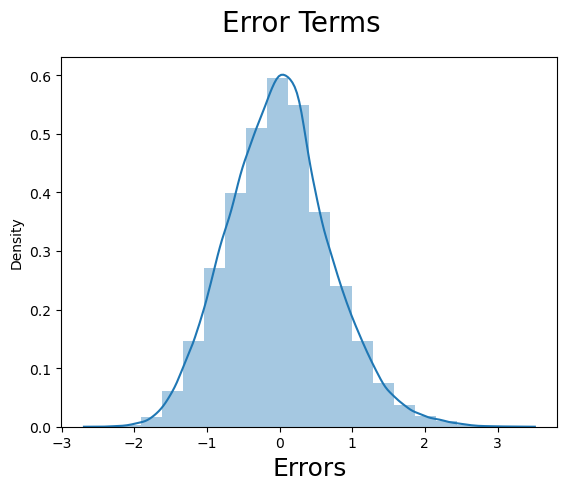

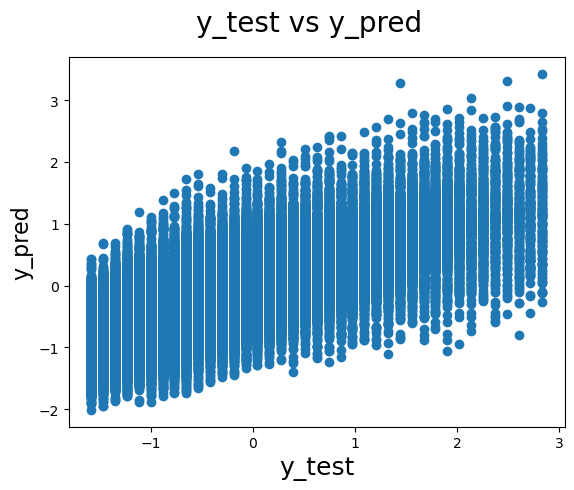

In [639]:
#  We will do histogram for error terms & y_test_pred to undertand the spread

y_train_pred = lr_final.predict(X_train_lm)

# # Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label



X_test = df_test[['distance', 'subtotal','total_outstanding_orders','isWeekend','isPeakHour','order_hour','num_distinct_items']]

X_test_lm = sm.add_constant(X_test)
y_pred = lr_final.predict(X_test_lm)
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)   





[Your inferences here:]
Error terms are normally distributed which is an assumption of linear regression.
Spread of y_test and t_pred values are also tell us a linear relations ship.



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model
In the final model I used features which are all scales. It helps us to make intrepretation easily.

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'
const                    - 5.009e-17 - With value of "5.009e-17" and  P value of 1 it has negligibile impact on the outcome.
distance                 - 0.4350 - Distance seems to be highly correlated. The higher the distance longer the delivery time
subtotal                 - 0.3145 - Higher order values increase delivery time.
total_outstanding_orders - 0.2486 - Busier times result in longer delivery.
order_hour               - -0.1840 - Late hours seems to decrease order time. Probably due to less trafiic
isWeekend                - 0.0858 - Weekend has slightly longer delivery time. Probably due to traffic or low availability of dashers
total_items              - 0.0237 - More items increases the delivery time slightly


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**.
> Yes there are categorical variables. In the final model they did not have any effect on the dependent variable(delivery time)



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> That mean 20% of the total data is kept aside as test set



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> "distance" feature has the highest correlation with "delivery time"

##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> I have used box plot to figure out the outliers for distance, subtotal, total outstanding orders & delivery time. I have removed them from the data set



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Distance, Subtotal & Total Outstanding Orders are the features which affect delivery time the most

#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear Regression model assumes a linear relationship between the target variable and one or more independent variable. Linear regression algorithm basically try to fit best fit straight line between target and predictor variables.
> Linear regression formula is Y=β0​+β1​X+ϵ . Beta0 is the intercept of the line, Beta1 is the slope of the line and Epsilon is the error terms & X is the predictor variable
> In case of multiple linear regression the formula becomes Y=β0​+β1​X1​+β2​X2​+⋯+βn​Xn​+ϵ with multiple predictor values.
> Objective of the linear regression is to find the best values for coefficients or beta values. It is done by getting minimal residual sum of squares.
> Below are the major assumptions of linear regression
> Linearity
> Independence - Residual errors are basically not dependent on each other
> Normal Distribution of residual errors
> Homoscedasticity - variance of error should be constant across independent variables
> No Multicollinearity - independent variables should not be collinear with each other




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> In simple linear regression there is only one independent variables and for multi linear regression it will be more than one independent variable. For equation we can refer above answer



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> Cost functions tells us how good the predicted and actual values are matching from a regression model. Most common method or cost funtion is is the Mean Squared Error (MSE). They are reduced by reducing the error between predicted and actual values. This can be adjusted by changing the beta or coeffiecient values




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Underfitting basically means a very simple regression model which does not capture the trends in the data. It predicts badly with unseen data as well as training data.
> Overfitting is when the model almost memorising the training data. It performs well in traing data but poorly in new data. It fails to generalise the relationship



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plot basically plots the predicted value and actual value. Residuals should not show us a pattern and shoul dbe randomly scatterd. Residual should also follow a normal distribution. We can also use is to see if there are influential outliers which might lie far from the clustered residuals